In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path  = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0006R0_f01920.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f02040.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08111.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f02100_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_008340_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f02730_P.png')]

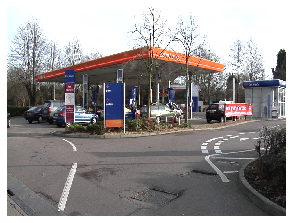

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize = (5,5))

In [0]:
get_y_fn = lambda x : path_lbl/f'{x.stem}_P{x.suffix}'

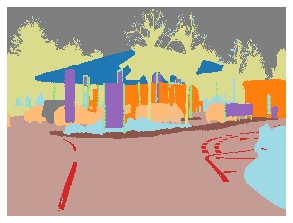

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize = (5,5),alpha = 1)

In [0]:
src_size = np.array(mask.shape[1:])

In [13]:
src_size

array([720, 960])

In [14]:
mask.data

tensor([[[21, 21, 21,  ..., 21, 21, 21],
         [21, 21, 21,  ..., 21, 21, 21],
         [21, 21, 21,  ..., 21, 21, 21],
         ...,
         [17, 17, 17,  ..., 17, 17, 17],
         [17, 17, 17,  ..., 17, 17, 17],
         [17, 17, 17,  ..., 17, 17, 17]]])

In [0]:
codes = np.loadtxt(path/'codes.txt',dtype = str)

In [18]:
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

Datasets

In [0]:
size = src_size//2

free = gpu_mem_get_free_no_cache()

In [20]:
free

16270

In [0]:
#as free >0 , setting batchsize to 8

In [0]:
bs = 8

In [0]:
src = (SegmentationItemList.from_folder(path_img).
       split_by_fname_file('../valid.txt').
       label_from_func(get_y_fn,classes = codes))

In [0]:
data = (src.transform(get_transforms(),size = size,tfm_y = True).
        databunch(bs = bs).
        normalize(imagenet_stats))

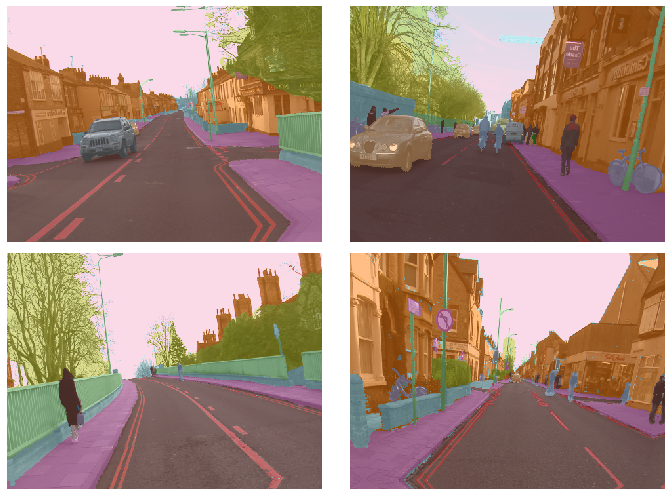

In [26]:
data.show_batch(2,figsize = (10,7))

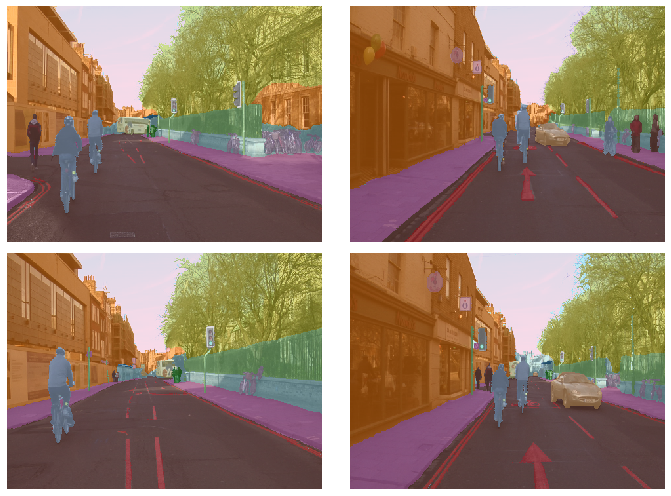

In [28]:
data.show_batch(2,figsize = (10,7),ds_type = DatasetType.Valid)

Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code  = name2id['Void']

def acc_camvid(input,target):
    target=  target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics = acc_camvid

In [0]:
wd = 1e-2
# look up weight decay

In [37]:
doc(unet_learner)

In [39]:
learn = unet_learner(data,models.resnet34,metrics = metrics,wd = wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 97.8MB/s]


In [40]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


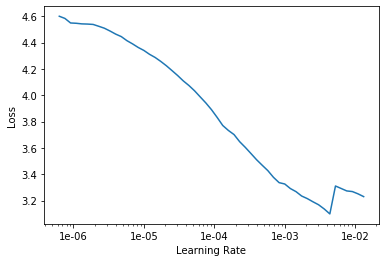

In [42]:
learn.recorder.plot()

In [0]:
lr = 3e-3

In [44]:
learn.fit_one_cycle(10,slice(lr),pct_start = 0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.263337,0.949859,0.734783,00:55
1,0.865656,0.687941,0.818383,00:52
2,0.710459,0.522111,0.853443,00:52
3,0.627529,0.456102,0.869124,00:53
4,0.618945,0.455678,0.881639,00:52
5,0.672834,0.480359,0.867233,00:51
6,0.586974,0.495863,0.864748,00:52
7,0.553978,0.443097,0.873621,00:52
8,0.509484,0.415432,0.890258,00:52
9,0.465704,0.330196,0.906244,00:52


In [0]:
learn.save('stage-1')

In [46]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

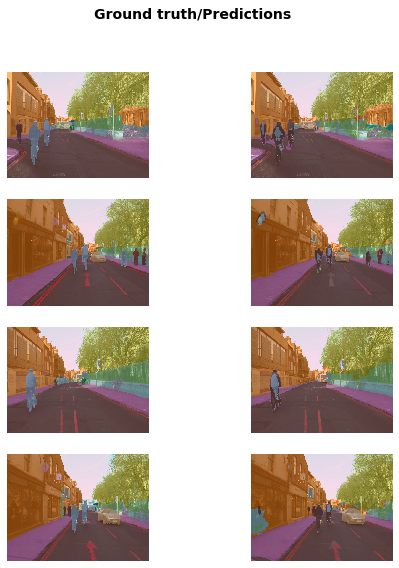

In [47]:
learn.show_results(rows=4,figsize = (8,9))

getting there...
training more

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [50]:
learn.fit_one_cycle(12,lrs,pct_start = 0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.394331,0.321428,0.905486,00:54
1,0.384219,0.320874,0.906750,00:53
2,0.374154,0.308638,0.911587,00:53
3,0.361019,0.319233,0.905766,00:54
4,0.353525,0.313296,0.911592,00:54
5,0.340272,0.306125,0.913095,00:53
6,0.326750,0.313841,0.912102,00:53
7,0.325238,0.285170,0.921962,00:53
8,0.316103,0.272481,0.927582,00:53
9,0.298574,0.296381,0.917567,00:53


In [0]:
learn.save('stage-2')

decent accuracy achieved : 92.7%

further ideas:
    - train on the full image size 
        - use transfer learning to train quicker : use the 128*128 model's weights as the initial weights for the 256*256 model
        